In [1]:
########################################################################
# QuTiP example for 6 qubit bath environment
########################################################################

!pip install qutip --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 21.4 MB/s eta 0:00:00


Libraries imported successfully!
QUANTUM SIMULATOR v2.0 (AUTO-DOWNLOAD MODE)
-------------------------------------------
Options:
1. Single simulation (results auto-download)
2. Batch simulations (each run auto-downloads)
Choose 1 or 2: 1

🚀 Running single simulation...


/usr/local/lib/python3.12/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/qutip/core/data/expm.py:139: LinAlgWarning: Matrix is ill-conditioned. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


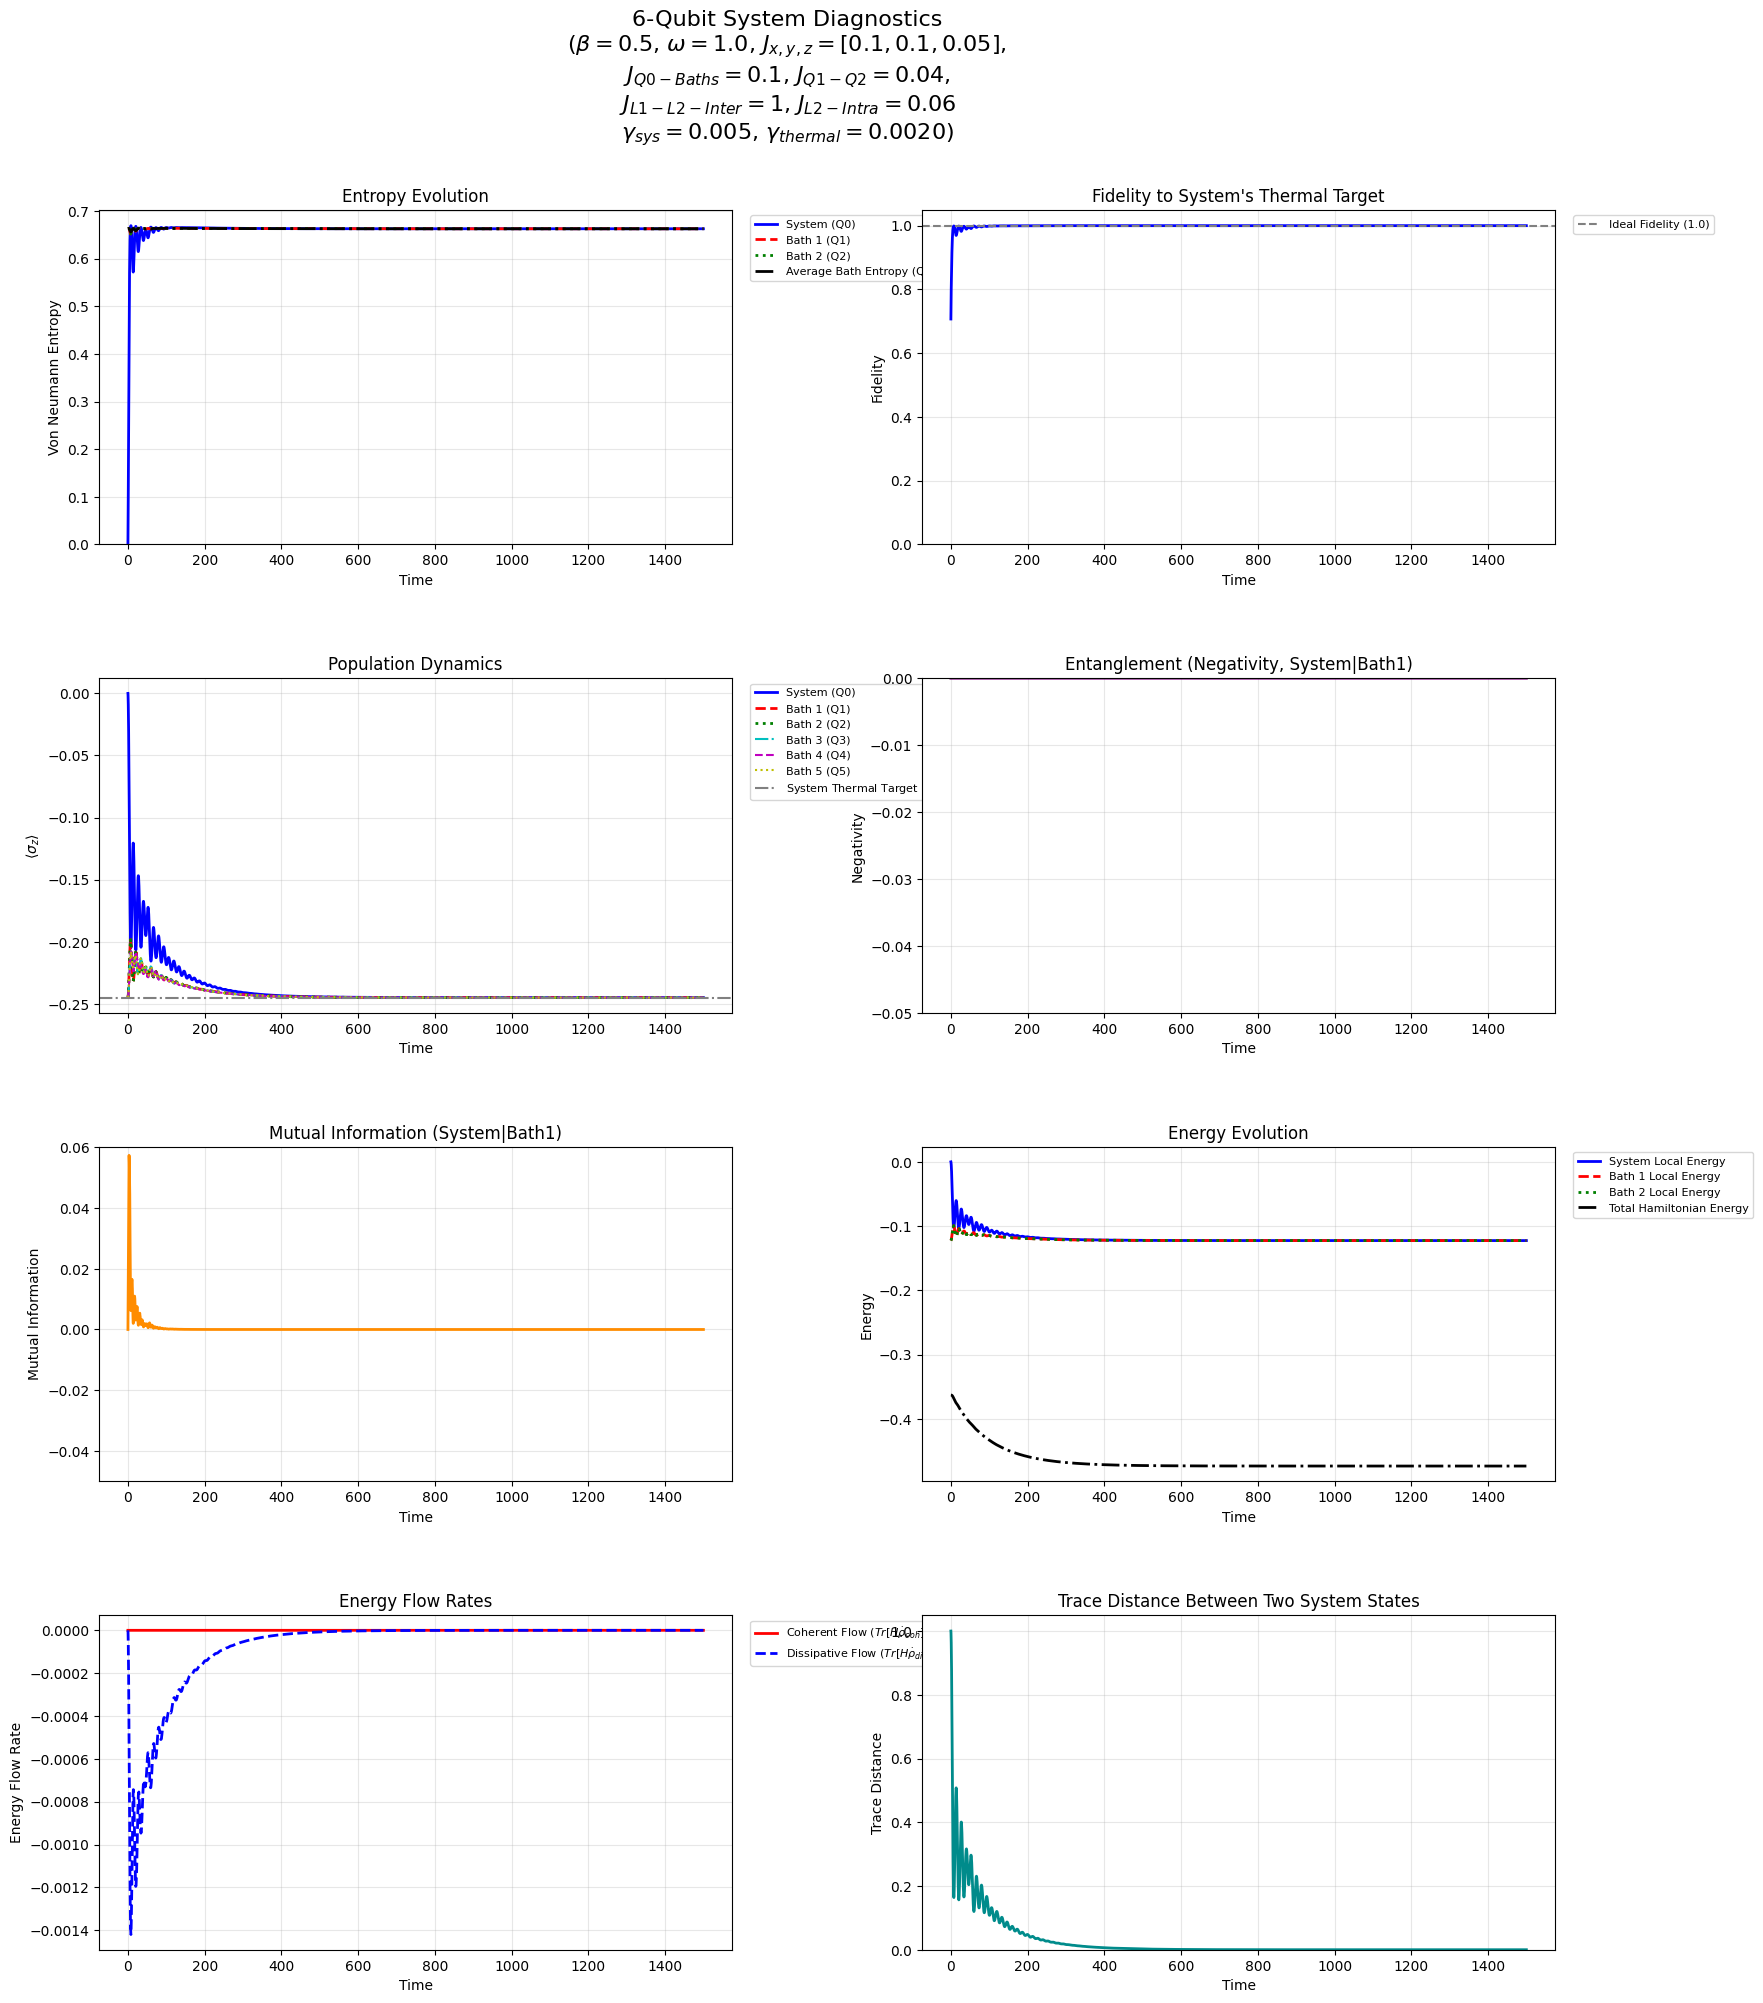

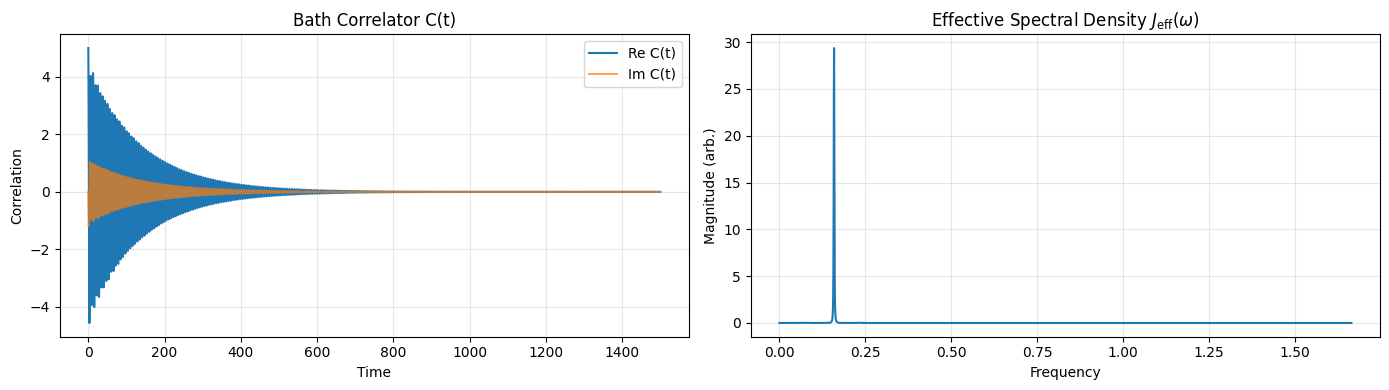

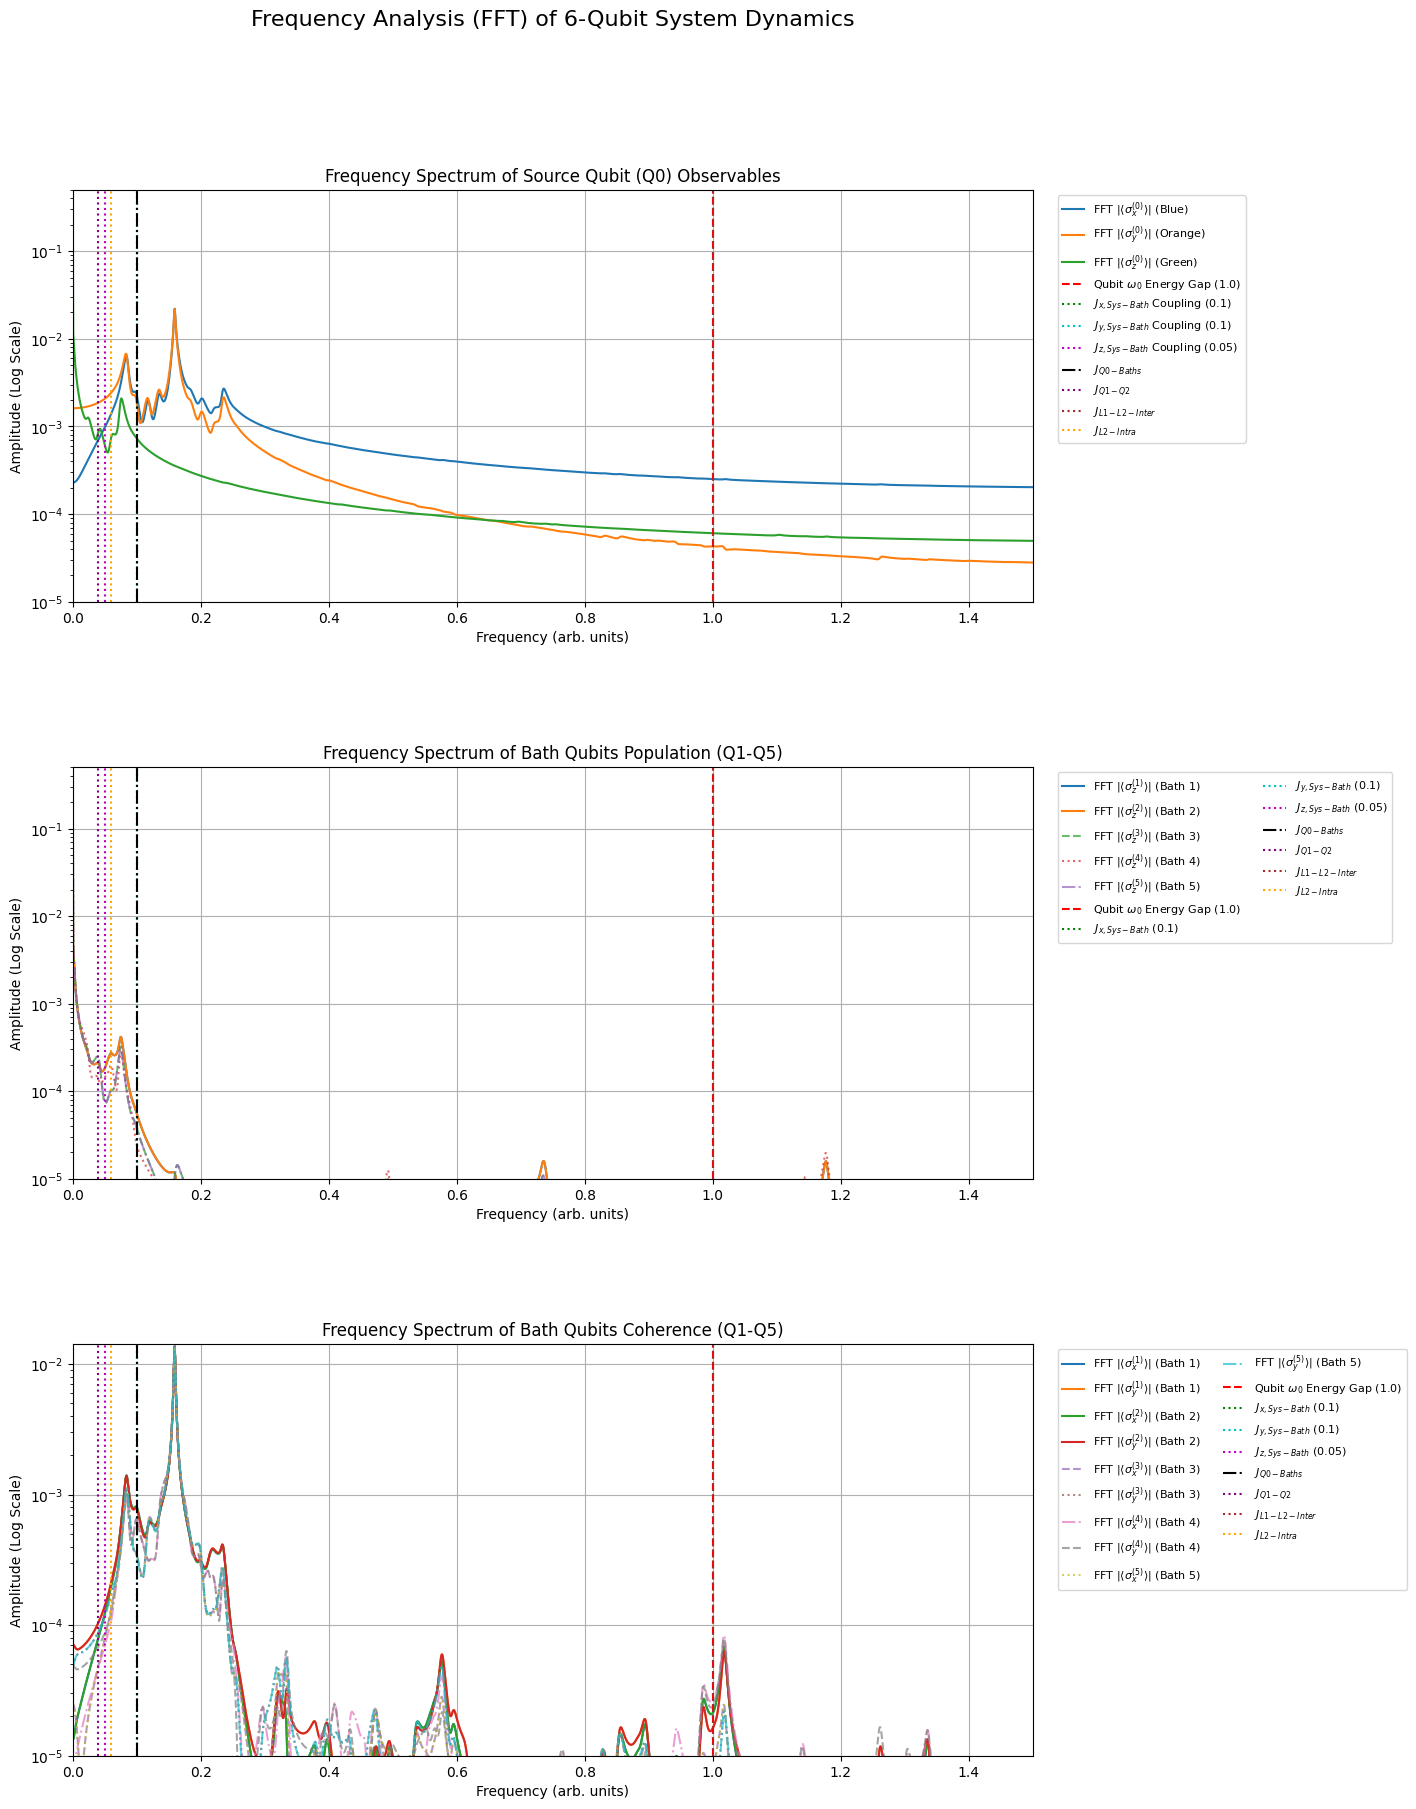

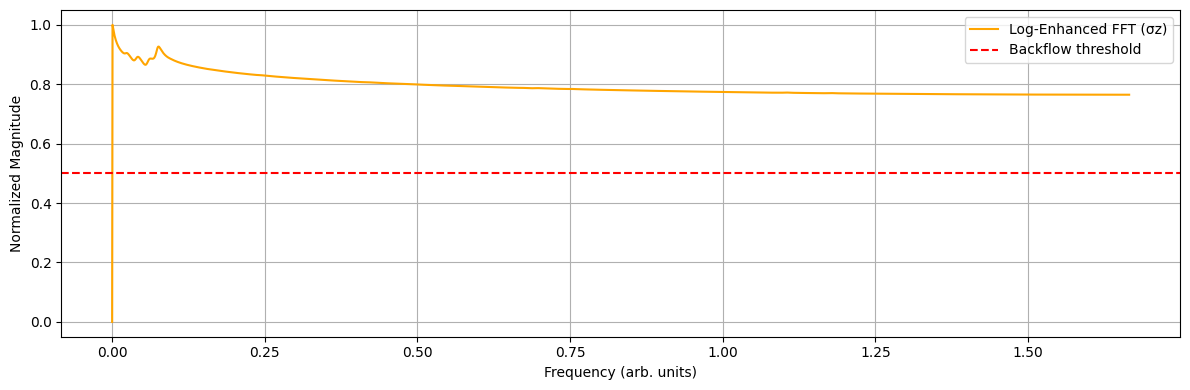

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
########################################################################
# Imports & setup
########################################################################


# General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
import random

from io import StringIO
import sys
from datetime import datetime
from IPython.display import FileLink, display, clear_output
from ipywidgets import widgets, Layout
from scipy.linalg import eig

# QuTiP imports
from qutip import (
    correlation_2op_1t, Qobj, basis, ket2dm, thermal_dm, tensor, qeye,
    sigmax, sigmay, sigmaz, sigmap, sigmam,
    expect, mesolve, Options, entropy_vn, fidelity, negativity,
    tracedist
)
from scipy.fft import fft, fftfreq

print("Libraries imported successfully!")

# =============================================
# Wrapper Functionality
# =============================================


def generate_random_parameters():
    """Generate random parameters within specified ranges"""
    params = {
        'J_source_to_bath': random.uniform(0.1, 0.5),
        'J_layer1_intra_bath': random.uniform(0.5, 0.99),
        'J_layer1_to_layer2_inter': random.uniform(0.01, 0.1),
        'J_layer2_intra_bath': random.uniform(0.5, 0.99),
        'gamma_thermal_layer1': random.uniform(0.001, 0.01),
        'gamma_thermal_layer2': random.uniform(0.001, 0.01)
    }
    return params

def run_multiple_simulations(num_runs):
    """Run the simulation multiple times with random parameters"""
    # Create output directory if it doesn't exist
    if not os.path.exists('multi_run_results'):
        os.makedirs('multi_run_results')

    # Clear any existing progress bars
    clear_output(wait=True)

    # Display progress bar
    progress = widgets.IntProgress(
        value=0,
        min=0,
        max=num_runs,
        description='Progress:',
        bar_style='info',
        style={'bar_color': 'blue'},
        layout=Layout(width='50%')
    )
    display(progress)
    for i in range(1, num_runs + 1):
        clear_output(wait=True)
        display(progress)

        print(f"\n=== Starting Simulation Run {i}/{num_runs} ===")

        # Generate random parameters
        params = generate_random_parameters()

        # Create a string buffer for this run's output
        run_output_buffer = StringIO()
        sys.stdout = run_output_buffer

        try:
            print("Using parameters:")
            for param, value in params.items():
                print(f"  {param}: {value:.4f}")

            # Run simulation with these parameters
            run_single_simulation(params, i)

            # Save the output
            output_filename = os.path.join('multi_run_results', f"run_{i}_output.txt")
            with open(output_filename, 'w') as f:
                f.write(run_output_buffer.getvalue())

        finally:
            # Restore stdout
            sys.stdout = sys.__stdout__

        progress.value = i
        print(f"=== Completed Simulation Run {i}/{num_runs} ===")


        # Display intermediate results
        if i < num_runs:
            clear_output(wait=True)
            display(progress)

    # After all runs complete
    clear_output(wait=True)
    print(f"\nAll {num_runs} simulations completed!")
    display_saved_results()

def zip_all_results():
    """Create a zip file of all results"""
    zip_filename = 'all_simulation_results.zip'
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, _, files in os.walk('multi_run_results'):
            for file in files:
                zipf.write(os.path.join(root, file),
                          os.path.relpath(os.path.join(root, file),
                                         os.path.join('multi_run_results', '..')))

    print(f"\nCreated {zip_filename} with all results")
    display(FileLink(zip_filename))


# =============================================
# Numerical Stability Helpers (for Fidelity/Entropy)
# =============================================

def _regularize_dm(rho, eps=1e-12):
    """
    Make density matrix Hermitian, positive semi-definite, and normalized.
    Clips tiny negatives caused by round-off, avoids ill-conditioning.
    """
    A = 0.5 * (rho.full() + rho.full().conj().T)
    evals, evecs = np.linalg.eigh(A)
    evals = np.clip(evals.real, 0.0, None)
    Apos = (evecs @ np.diag(evals) @ evecs.conj().T)
    tr = Apos.real.trace()
    if tr <= eps:
        d = rho.shape[0]
        Apos = np.eye(d) / d
    else:
        Apos /= tr
    return Qobj(Apos, dims=rho.dims)

def fidelity_safe(rho, sigma, eps=1e-12):
    """
    Compute Uhlmann fidelity robustly, avoiding ill-conditioned sqrtm warnings.
    Uses eigen-decomposition instead of scipy.linalg.sqrtm.
    """
    rho = _regularize_dm(rho, eps)
    sigma = _regularize_dm(sigma, eps)

    # sqrt(rho)
    w, U = np.linalg.eigh(rho.full())
    w = np.clip(w.real, 0.0, None)
    sqrt_rho = (U @ np.diag(np.sqrt(w)) @ U.conj().T)

    # Build M = sqrt(rho) * sigma * sqrt(rho)
    M = sqrt_rho @ sigma.full() @ sqrt_rho

    # Fidelity = (sum sqrt(eigenvalues of M))^2
    evals = np.linalg.eigvalsh(0.5 * (M + M.conj().T))  # ensure Hermitian
    evals = np.clip(evals.real, 0.0, None)
    F = (np.sum(np.sqrt(evals)))**2
    return float(max(0.0, min(1.0, F)))

def entropy_vn_safe(rho, base=2, eps=1e-12):
    """
    Von Neumann entropy with eigenvalue cleanup to avoid log of negative/zero.
    """
    rho = _regularize_dm(rho, eps)
    evals = np.clip(np.linalg.eigvalsh(rho.full()).real, 0.0, 1.0)
    evals = evals[evals > eps]
    if evals.size == 0:
        return 0.0
    return float((-np.sum(evals * np.log(evals))) / np.log(base))



# =============================================
# Utility Functions
# =============================================

def thermal_state(beta, H):
    """Create thermal state for given Hamiltonian and inverse temperature"""
    Z = (-beta * H).expm().tr()
    return ((-beta * H).expm() / Z).unit()

def get_tensor_op(op, idx, total_qubits):
    """Returns a tensor product operator with 'op' at 'idx' and Identity elsewhere."""
    op_list = [qeye(2)] * total_qubits
    op_list[idx] = op
    return tensor(op_list)

def lindblad_dissipator(L, rho):
    """Lindblad dissipator: L ρ L† - 1/2 {L†L, ρ} (for conceptual understanding and specific dH/dt calculation)"""
    return L * rho * L.dag() - 0.5 * (L.dag() * L * rho + rho * L.dag() * L)

def get_thermal_lindblad_operators(beta, omega, gamma, loc, total_qubits):
    """
    Get thermal Lindblad operators for a qubit with energy gap omega.
    These operators model dissipation to a thermal bath, causing the qubit
    to relax to a thermal state at the given inverse temperature beta.

    Args:
        beta (float): Inverse temperature (1/kT).
        omega (float): Energy gap of the qubit.
        gamma (float): Dissipation rate.
        loc (int): Qubit index (0=system, 1=bath1, ..., total_qubits-1=last bath) to apply operators to.
        total_qubits (int): Total number of qubits in the system.
    """
    if beta * omega > 20: # Prevent overflow for very low temperatures
        n_th = 0.0
    elif beta * omega < 1e-6: # Handle very high temperatures
        n_th = 1/(beta * omega)
    else:
        n_th = 1 / (np.exp(beta * omega) - 1)

    sm = sigmam()
    sp = sigmap()

    # Use the new get_tensor_op helper for n-qubit systems
    L_down = np.sqrt(gamma * (1 + n_th)) * get_tensor_op(sm, loc, total_qubits)
    L_up = np.sqrt(gamma * n_th) * get_tensor_op(sp, loc, total_qubits)

    return [L_down, L_up]

def blp_backflow_dt_invariant(tlist, td_array, smooth_win=31, poly=3,
                              rel_thresh=3.0, abs_floor=1e-7):
    """
    Robust, grid-invariant BLP backflow from a trace-distance time series.
    - Smooth TD (Savitzky–Golay if available; fallback: moving average)
    - Threshold tiny derivatives estimated from the tail (noise floor)
    - Integrate positive slope over time (trapz) -> independent of dt
    """
    import numpy as np
    try:
        from scipy.signal import savgol_filter
        w = min(smooth_win, len(td_array) - (1 - len(td_array) % 2))  # odd <= len
        if w < 5:
            w = 5 if len(td_array) >= 5 else (len(td_array) | 1)
        td_s = savgol_filter(td_array, window_length=w, polyorder=min(poly, w-2), mode='interp')
    except Exception:
        k = min(smooth_win, len(td_array))
        if k % 2 == 0: k -= 1
        if k < 3: k = 3
        td_s = np.convolve(td_array, np.ones(k)/k, mode='same')

    dDdt = np.gradient(td_s, tlist)
    tail = dDdt[int(0.8*len(dDdt)):] if len(dDdt) > 10 else dDdt
    floor = np.median(np.abs(tail))
    eps = max(abs_floor, rel_thresh * floor)

    pos = np.maximum(dDdt - eps, 0.0)
    return float(np.trapezoid(pos, tlist))


# =============================================
# Result Display Functions
# =============================================

def display_saved_results():
    """Display all saved simulation results"""
    if not os.path.exists('multi_run_results'):
        print("No results found. Please run simulations first.")
        return

    print("\nSaved Simulation Results:")
    results = os.listdir('multi_run_results')
    if not results:
        print("No results found in multi_run_results directory.")
        return

    # Group results by run
    run_ids = set()
    for file in results:
        if file.startswith('run_'):
            run_id = file.split('_')[1]  # Extract run number
            run_ids.add(run_id)

    print(f"Found {len(run_ids)} simulation runs:")
    for run_id in sorted(run_ids):
        print(f"- Run {run_id}")

    # Create download link for all results
    zip_all_results()

def zip_all_results():
    """Create a zip file of all results"""
    if not os.path.exists('multi_run_results'):
        print("No results to zip.")
        return

    zip_filename = 'all_simulation_results.zip'
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, _, files in os.walk('multi_run_results'):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, 'multi_run_results'))

    print(f"\nCreated {zip_filename} with all results")
    display(FileLink(zip_filename))


# =============================================
# Main Simulation Function
# =============================================

def run_single_simulation(params, run_number=None):
    """Run a single simulation with given parameters"""
    # Create a string buffer to capture output
    output_buffer = StringIO()
    sys.stdout = output_buffer
    # Unpack parameters
    J_source_to_bath = params['J_source_to_bath']
    J_layer1_intra_bath = params['J_layer1_intra_bath']
    J_layer1_to_layer2_inter = params['J_layer1_to_layer2_inter']
    J_layer2_intra_bath = params['J_layer2_intra_bath']
    gamma_thermal_layer1 = params['gamma_thermal_layer1']
    gamma_thermal_layer2 = params['gamma_thermal_layer2']

    # --- Simulation Parameters ---
    total_qubits = 6 # Define total number of qubits here (Q0-Q5)
    beta = 0.5       # Inverse temperature (1 / (kB * T)). Moderate temperature.
    omega = 1.0      # Energy gap (frequency) for all qubits. Defines the local energy.
    J_x = 0.1        # System-bath XY coupling strength in X-direction
    J_y = 0.1        # System-bath XY coupling strength in Y-direction
    J_z = 0.05       # System-bath Z coupling strength (Heisenberg-like interaction)
    gamma_sys = 0.005 # System pure dephasing rate.

    # --- Updated Time Grid ---
    t_max = 1500                  # Total simulation time (unchanged)
    num_points = 5000             # Increase number of time points for finer resolution
    tlist = np.linspace(0, t_max, num_points)
    dt = tlist[1] - tlist[0]      # Updated time step
    print(f"dt = {dt:.4f}, Nyquist = {1/(2*dt):.3f}")

    print(f"\nSimulation Parameters (Total Qubits: {total_qubits}):")
    print(f"    System/Bath Energy Gap (omega): {omega:.2f}")
    print(f"    Inverse Temperature (beta): {beta:.2f} (Temperature T = {1/beta:.2f})")
    print(f"    Thermal Occupation Number (n_th): {1 / (np.exp(beta * omega) - 1) if beta * omega > 1e-6 else 'N/A (high temp)' :.3f}")
    print(f"    System-Bath XY/Z Couplings (Jx, Jy, Jz): {J_x:.3f}, {J_y:.3f}, {J_z:.3f}")
    print(f"    J_source_to_bath (Q0-Q1, Q0-Q2): {J_source_to_bath:.3f}")
    print(f"    J_layer1_intra_bath (Q1-Q2): {J_layer1_intra_bath:.3f}")
    print(f"    J_layer1_to_layer2_inter (Q1-Q3, Q1-Q4, Q2-Q4, Q2-Q5): {J_layer1_to_layer2_inter:.3f}")
    print(f"    J_layer2_intra_bath (Q3-Q4, Q4-Q5): {J_layer2_intra_bath:.3f}")
    print(f"    System Dephasing Rate (gamma_sys): {gamma_sys:.4f}")
    print(f"    Bath Thermalization Rate (gamma_thermal): Layer 1 = {gamma_thermal_layer1:.4f}, Layer 2 = {gamma_thermal_layer2:.4f}")
    print(f"    Simulation Time Range: 0 to {t_max} (Number of points: {num_points})")

    # --- Initial States ---
    # System qubit (Q0) starts in an equal superposition state
    psi_sys = (basis(2, 0) + basis(2, 1)).unit() # |+> state
    rho_sys = ket2dm(psi_sys) # Density matrix for the system qubit

    # Baths (Q1 to Q5) start in individual thermal states
    H_single_qubit = 0.5 * omega * sigmaz()
    rho_bath = thermal_state(beta, H_single_qubit) # All baths use the same thermal state

    # Total initial state of the 6-qubit system (System, Bath1, ..., Bath5)
    initial_states_list = [rho_sys] + [rho_bath] * (total_qubits - 1)
    rho0 = tensor(initial_states_list)

    # Define the thermal target state for the system (used for fidelity calculation)
    thermal_target_state_sys = thermal_state(beta, 0.5 * omega * sigmaz())

    print("\nInitial State Information:")
    print(f"    Initial system entropy: {entropy_vn(rho_sys):.3f}")
    print(f"    Initial bath (Q1-Q5) individual entropy: {entropy_vn(rho_bath):.3f}")

    # --- Operators for Each Qubit ---
    # Identity operator for a 2-level system (qubit)
    I_q = qeye(2) # Single qubit identity

    # Pauli operators for all qubits (Q0 to Q5) in the 6-qubit Hilbert space
    sx_ops = [get_tensor_op(sigmax(), i, total_qubits) for i in range(total_qubits)]
    sy_ops = [get_tensor_op(sigmay(), i, total_qubits) for i in range(total_qubits)]
    sz_ops = [get_tensor_op(sigmaz(), i, total_qubits) for i in range(total_qubits)]

    # For convenience, keep direct references for Q0, Q1, Q2 (used in plotting later)
    sx0, sy0, sz0 = sx_ops[0], sy_ops[0], sz_ops[0]
    sx1, sy1, sz1 = sx_ops[1], sy_ops[1], sz_ops[1]
    sx2, sy2, sz2 = sx_ops[2], sy_ops[2], sz_ops[2]
    sx3, sy3, sz3 = sx_ops[3], sy_ops[3], sz_ops[3]
    sx4, sy4, sz4 = sx_ops[4], sy_ops[4], sz_ops[4]
    sx5, sy5, sz5 = sx_ops[5], sy_ops[5], sz_ops[5]

    # --- Hamiltonian Construction ---
    # 1. Local Hamiltonians (On-site energies of each qubit)
    H_local_terms = [0.5 * omega * sz_ops[i] for i in range(total_qubits)]
    H_local = sum(H_local_terms)

    # 2. Interaction Hamiltonians (Couplings between qubits)
    H_interaction_terms = []

    # Connections directly from Source (Q0) to first layer of Baths (Q1, Q2)
    H_interaction_terms.append(J_source_to_bath * (sx0*sx1 + sy0*sy1 + sz0*sz1)) # Q0-Q1
    H_interaction_terms.append(J_source_to_bath * (sx0*sx2 + sy0*sy2 + sz0*sz2)) # Q0-Q2

    # Intra-layer 1 connection (Q1-Q2)
    H_interaction_terms.append(J_layer1_intra_bath * (sx1*sx2 + sy1*sy2 + sz1*sz2)) # Q1-Q2

    # Connections between Layer 1 and Layer 2 Baths
    H_interaction_terms.append(J_layer1_to_layer2_inter * (sx1*sx3 + sy1*sy3 + sz1*sz3)) # Q1-Q3
    H_interaction_terms.append(J_layer1_to_layer2_inter * (sx1*sx4 + sy1*sy4 + sz1*sz4)) # Q1-Q4
    H_interaction_terms.append(J_layer1_to_layer2_inter * (sx2*sx4 + sy2*sy4 + sz2*sz4)) # Q2-Q4
    H_interaction_terms.append(J_layer1_to_layer2_inter * (sx2*sx5 + sy2*sy5 + sz2*sz5)) # Q2-Q5

    # Intra-layer 2 connections (Q3-Q4, Q4-Q5)
    H_interaction_terms.append(J_layer2_intra_bath * (sx3*sx4 + sy3*sy4 + sz3*sz4)) # Q3-Q4
    H_interaction_terms.append(J_layer2_intra_bath * (sx4*sx5 + sy4*sy5 + sz4*sz5)) # Q4-Q5

    # Total Interaction Hamiltonian
    H_interaction = sum(H_interaction_terms)

    # Total Hamiltonian for the 6-qubit system
    H_total = H_local + H_interaction

    print("\nHamiltonian Information:")
    print(f"    Total Hamiltonian trace: {H_total.tr():.6f} (should be close to 0 for traceless Pauli operators)")
    print(f"    Coupling J_source_to_bath (Q0-Q1, Q0-Q2): {J_source_to_bath:.6f}")
    print(f"    Coupling J_layer1_intra_bath (Q1-Q2): {J_layer1_intra_bath:.6f}")
    print(f"    Coupling J_layer1_to_layer2_inter (Q1-Q3, Q1-Q4, Q2-Q4, Q2-Q5): {J_layer1_to_layer2_inter:.6f}")
    print(f"    Coupling J_layer2_intra_bath (Q3-Q4, Q4-Q5): {J_layer2_intra_bath:.6f}")

    # --- Dissipator (Collapse) Operators ---
    # Collapse operators model the irreversible processes (dissipation, dephasing).

    # 1. Pure dephasing on the system qubit (Q0)
    L_deph_sys = np.sqrt(gamma_sys) * sz_ops[0]

    # 2. Thermal dissipation with separate gamma values for Layer 1 and Layer 2 baths
    L_thermal_ops = []
    for i in range(1, total_qubits):  # Q1 to Q5
        if i in [1, 2]:  # Layer 1: Q1, Q2
            gamma_i = gamma_thermal_layer1
        else:  # Layer 2: Q3, Q4, Q5
            gamma_i = gamma_thermal_layer2

        L_thermal_ops.extend(get_thermal_lindblad_operators(beta, omega, gamma_i, loc=i, total_qubits=total_qubits))

    # Combine all collapse operators into a single list for mesolve
    c_ops = [L_deph_sys] + L_thermal_ops

    print("\nDissipator Information:")
    print(f"    Number of collapse operators: {len(c_ops)}")

    # --- Bath Correlator & Effective Spectral Density (continuum bridge) ---
    # Define a bath operator B = sum_i c_i * sigma_x(i) over bath qubits (Q1..Q5).
    bath_indices = [1, 2, 3, 4, 5]
    c_weights = {i: 1.0 for i in bath_indices}

    def sx_on(i, N):
        ops = [qeye(2)] * N
        ops[i] = sigmax()
        return tensor(ops)

    B = sum(c_weights[i] * sx_on(i, total_qubits) for i in bath_indices)

    print("\nComputing bath correlator C(t) via QuTiP ...")
    # C(t) = Tr[B(t) B(0) rho] under your full open dynamics (same H_total, c_ops, rho0)
    C_t = correlation_2op_1t(H_total, rho0, tlist, c_ops, B, B)  # complex array

    # Optional: window before FFT to reduce spectral leakage
    window = np.hanning(len(tlist))
    dt_corr = tlist[1] - tlist[0]
    C_t_win = C_t * window

    # Effective spectral density via FFT: J_eff(ω) ∝ |F[C(t)]|
    freq_corr = np.fft.fftshift(np.fft.fftfreq(len(tlist), d=dt_corr))
    J_eff = np.abs(np.fft.fftshift(np.fft.fft(C_t_win))) * dt_corr

    mask_pos = freq_corr >= 0
    freq_pos = freq_corr[mask_pos]
    J_pos = J_eff[mask_pos]
    dom_freq = float(freq_pos[np.argmax(J_pos)])
    print(f"Dominant J frequency (ω): {dom_freq:.6f}")

    print("  Correlator C(t) and J(ω) computed.")


    # --- DEPS & Petermann (corrected) ---
    print("\nCalculating Exceptional Point Proximity (DEPS)...")

    # Effective non-Hermitian Hamiltonian: H_eff = H_total - (i/2) * Σ L†L
    L_sum = sum([L.dag() * L for L in c_ops])
    H_eff = H_total - 0.5j * L_sum
    A = H_eff.full()  # dense ndarray

    # Single eig call → left/right eigenvectors aligned in the SAME order
    w, VL, VR = eig(A, left=True, right=True)   # w: eigenvalues, VL: left vecs (cols), VR: right vecs (cols)

    # 1) DEPS: minimum pairwise spacing in the complex plane
    dist = np.abs(w[:, None] - w[None, :])
    np.fill_diagonal(dist, np.inf)
    deps = float(np.min(dist))

    # Optional normalization by an energy scale (spectral radius of Re parts)
    R = float(np.max(np.abs(np.real(w)))) if w.size else 1.0
    if R == 0.0:
        R = 1.0
    deps_rel = deps / R

    # 2) Petermann factor (max). Use normalization-invariant form.
    #    K_k = (||L_k||^2 * ||R_k||^2) / |<L_k|R_k>|^2
    eps = 1e-14
    K_vals = []
    for k in range(len(w)):
        lk = VL[:, k]
        rk = VR[:, k]
        denom = np.vdot(lk, rk)  # <L_k|R_k>
        if np.abs(denom) < eps:
            K_vals.append(np.inf)
        else:
            K_vals.append( (np.vdot(lk, lk) * np.vdot(rk, rk)) / (np.abs(denom)**2) )

    petermann_max = float(np.max(np.real(K_vals))) if len(K_vals) else float("nan")

    print(f"  DEPS (min spacing):     {deps:.6e}  (relative: {deps_rel:.3e})")
    print(f"  Petermann factor (max): {petermann_max:.6e}")


    # --- Time Evolution with mesolve ---
    # Observables to track during the time evolution (expectation values)
    e_ops = []
    for i in range(total_qubits):
        e_ops.append(sx_ops[i])
        e_ops.append(sy_ops[i])
        e_ops.append(sz_ops[i])

    print("\nStarting time evolution using QuTiP's mesolve (6-qubit system)...")
    result = mesolve(
        H_total, rho0, tlist, c_ops, e_ops=e_ops,
        options=Options(atol=1e-10, rtol=1e-8, store_states=True)
    )
    print("Time evolution complete!")

    # >>> ADD THIS LINE (exports to global scope for later cells) <<<
    globals().update(dict(H_total=H_total, rho0=rho0, tlist=tlist, c_ops=c_ops, result=result))


    # Extract the expectation values
    exp_vals = {}
    for i in range(total_qubits):
        exp_vals[f'sx{i}'] = result.expect[i * 3 + 0]
        exp_vals[f'sy{i}'] = result.expect[i * 3 + 1]
        exp_vals[f'sz{i}'] = result.expect[i * 3 + 2]

    # For convenience, keep direct references for Q0, Q1, Q2
    exp_sx0 = exp_vals['sx0']
    exp_sy0 = exp_vals['sy0']
    exp_sz0 = exp_vals['sz0']
    exp_sx1 = exp_vals['sx1']
    exp_sy1 = exp_vals['sy1']
    exp_sz1 = exp_vals['sz1']
    exp_sx2 = exp_vals['sx2']
    exp_sy2 = exp_vals['sy2']
    exp_sz2 = exp_vals['sz2']

    # --- Analysis: Energy Conservation & Quantum Information Diagnostics ---
    dH_dt_list = []
    dH_coh_list = []
    dH_diss_list = []
    entropy_sys, entropy_bath1, entropy_bath2, entropy_bath_avg = [], [], [], []
    fidelity_sys, negativity_vals, mutual_info_01 = [], [], []
    E_sys, E_bath1, E_bath2, E_total_vals = [], [], [], []

    print("\nStarting consolidated analysis...")

    for i, state in enumerate(result.states):
        # Energy Conservation Calculations
        rho_dot_coherent_part = -1j * (H_total * state - state * H_total)
        L_rho = sum([lindblad_dissipator(L, state) for L in c_ops])

        dH_coh = 0.0
        dH_diss = expect(H_total, L_rho)
        dH_dt = dH_coh + dH_diss

        dH_dt_list.append(dH_dt)
        dH_coh_list.append(dH_coh)
        dH_diss_list.append(dH_diss)

        # Quantum Information Diagnostics Calculations
        rho_sys = state.ptrace(0)
        rho_bath1 = state.ptrace(1)
        rho_bath2 = state.ptrace(2)
        rho_bath_qubits = [state.ptrace(j) for j in range(1, total_qubits)]
        rho_01 = state.ptrace([0, 1])

        entropy_sys.append(entropy_vn(rho_sys))
        entropy_bath1.append(entropy_vn(rho_bath1))
        entropy_bath2.append(entropy_vn(rho_bath2))
        entropy_bath_avg.append(np.mean([entropy_vn(rb) for rb in rho_bath_qubits]))

        fidelity_sys.append(fidelity(rho_sys, thermal_target_state_sys))
        negativity_vals.append(negativity(rho_01, subsys=0))
        mutual_info_01.append(entropy_vn(rho_sys) + entropy_vn(rho_bath1) - entropy_vn(rho_01))

        E_sys.append(expect(H_local_terms[0], state))
        E_bath1.append(expect(H_local_terms[1], state))
        E_bath2.append(expect(H_local_terms[2], state))
        E_total_vals.append(expect(H_total, state))

    print("Analysis loop complete!")

    # Calculate total energy change
    delta_E_total = E_total_vals[-1] - E_total_vals[0]

    print("\nEnergy Conservation Check:")
    print(f"    Initial Total Energy: {E_total_vals[0]:.6f}")
    print(f"    Final Total Energy: {E_total_vals[-1]:.6f}")
    print(f"    ΔE_total (Final - Initial): {delta_E_total:.6f}")

    # --- Simulation Summary ---
    print("\n" + "="*50)
    print("SIMULATION SUMMARY")
    print("="*50)
    print(f"    Final system entropy: {entropy_sys[-1]:.4f}")
    print(f"    Final fidelity to system's thermal target: {fidelity_sys[-1]:.4f}")
    print(f"    Final negativity (System|Bath1): {negativity_vals[-1]:.4f}")
    print(f"    Final mutual information (System|Bath1): {mutual_info_01[-1]:.4f}")
    print(f"    Energy conservation check: ΔE_total = {delta_E_total:.6f}")
    print(f"    Final system population: ⟨σ_z⟩ = {exp_sz0[-1]:.3f}")
    print(f"    Thermal target population for System: ⟨σ_z⟩ = {expect(sigmaz(), thermal_target_state_sys):.3f}")

    # --- Non-Markovianity Measure: Trace Distance Backflow ---
    print("\nEvaluating Non-Markovianity via Trace Distance Backflow...")

    # Define two orthogonal initial states for the system qubit
    psi_sys_1 = basis(2, 0) # |0> state
    psi_sys_2 = basis(2, 1) # |1> state

    initial_states_list_1 = [ket2dm(psi_sys_1)] + [rho_bath] * (total_qubits - 1)
    initial_states_list_2 = [ket2dm(psi_sys_2)] + [rho_bath] * (total_qubits - 1)

    rho0_1 = tensor(initial_states_list_1)
    rho0_2 = tensor(initial_states_list_2)

    # Evolve both initial states
    result1 = mesolve(H_total, rho0_1, tlist, c_ops, options=Options(atol=1e-10, rtol=1e-8, store_states=True))
    result2 = mesolve(H_total, rho0_2, tlist, c_ops, options=Options(atol=1e-10, rtol=1e-8, store_states=True))

    trace_dists = []
    for r1_state, r2_state in zip(result1.states, result2.states):
        rho_sys_1 = r1_state.ptrace(0)
        rho_sys_2 = r2_state.ptrace(0)
        td = tracedist(rho_sys_1, rho_sys_2)
        trace_dists.append(td)

    td_array = np.array(trace_dists)
    backflow = blp_backflow_dt_invariant(tlist, td_array)
    backflow_rate = backflow / (tlist[-1] - tlist[0])
    print(f"Backflow rate (per unit time): {backflow_rate:.6g}")
    print(f"Trace distance range: min={td_array.min():.4f}, max={td_array.max():.4f}")


    print("Non-Markovianity evaluation complete!")
    print(f"    Total trace distance backflow (Non-Markovianity measure): {backflow:.8f}")
    if backflow > 1e-4:
        print("    -> Evidence of non-Markovian behavior detected!")
    else:
        print("    -> Behavior appears Markovian.")

    # --- Plotting: Standard Diagnostics ---
    print("\nGenerating standard diagnostic plots...")

    fig_diag, axes = plt.subplots(4, 2, figsize=(16, 20))
    fig_diag.suptitle(f"6-Qubit System Diagnostics\n"
                      f"($\\beta={beta}$, $\\omega={omega}$, $J_{{x,y,z}}=[{J_x},{J_y},{J_z}]$,\n"
                      f"$J_{{Q0-Baths}}={J_source_to_bath}$, $J_{{Q1-Q2}}={J_layer1_intra_bath}$,\n"
                      f"$J_{{L1-L2-Inter}}={J_layer1_to_layer2_inter}$, $J_{{L2-Intra}}={J_layer2_intra_bath}$\n"
                      f"$\\gamma_{{sys}}={gamma_sys}$, $\\gamma_{{thermal}}={gamma_thermal_layer1:.4f}$)",
                      fontsize=16, y=1.02)

    fig_diag.subplots_adjust(hspace=0.4, wspace=0.3, top=0.92, bottom=0.05, left=0.07, right=0.98)

    # Plot 1: Entropy evolution
    axes[0, 0].plot(tlist, entropy_sys, 'b-', label="System (Q0)", linewidth=2)
    axes[0, 0].plot(tlist, entropy_bath1, 'r--', label="Bath 1 (Q1)", linewidth=2)
    axes[0, 0].plot(tlist, entropy_bath2, 'g:', label="Bath 2 (Q2)", linewidth=2)
    axes[0, 0].plot(tlist, entropy_bath_avg, 'k-.', label="Average Bath Entropy (Q1-Q5)", linewidth=2)
    axes[0, 0].set_ylabel("Von Neumann Entropy")
    axes[0, 0].set_title("Entropy Evolution")
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=8, ncol=1)
    axes[0, 0].set_xlabel("Time")
    axes[0, 0].set_ylim(bottom=0)

    # Plot 2: Fidelity to system's thermal target
    axes[0, 1].plot(tlist, fidelity_sys, 'b-', linewidth=2)
    axes[0, 1].axhline(1.0, color='gray', linestyle='--', label="Ideal Fidelity (1.0)")
    axes[0, 1].set_ylabel("Fidelity")
    axes[0, 1].set_title("Fidelity to System's Thermal Target")
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=8)
    axes[0, 1].set_xlabel("Time")
    axes[0, 1].set_ylim(0, 1.05)

    # Plot 3: Population dynamics (⟨σ_z⟩ expectation values)
    axes[1, 0].plot(tlist, exp_sz0, 'b-', label="System (Q0)", linewidth=2)
    axes[1, 0].plot(tlist, exp_sz1, 'r--', label="Bath 1 (Q1)", linewidth=2)
    axes[1, 0].plot(tlist, exp_sz2, 'g:', label="Bath 2 (Q2)", linewidth=2)
    axes[1, 0].plot(tlist, exp_vals['sz3'], 'c-.', label="Bath 3 (Q3)", linewidth=1.5)
    axes[1, 0].plot(tlist, exp_vals['sz4'], 'm--', label="Bath 4 (Q4)", linewidth=1.5)
    axes[1, 0].plot(tlist, exp_vals['sz5'], 'y:', label="Bath 5 (Q5)", linewidth=1.5)
    axes[1, 0].axhline(expect(sigmaz(), thermal_target_state_sys), color='gray', linestyle='-.', label="System Thermal Target $\\langle\\sigma_z\\rangle$")
    axes[1, 0].set_ylabel("$\\langle\\sigma_z\\rangle$")
    axes[1, 0].set_title("Population Dynamics")
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize=8)
    axes[1, 0].set_xlabel("Time")

    # Plot 4: Entanglement (Negativity between System and Bath 1)
    axes[1, 1].plot(tlist, negativity_vals, 'purple', linewidth=2)
    axes[1, 1].set_ylabel("Negativity")
    axes[1, 1].set_title("Entanglement (Negativity, System|Bath1)")
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlabel("Time")
    axes[1, 1].set_ylim(bottom=-0.05)

    # Plot 5: Mutual Information (System|Bath 1)
    axes[2, 0].plot(tlist, mutual_info_01, 'darkorange', linewidth=2)
    axes[2, 0].set_ylabel("Mutual Information")
    axes[2, 0].set_title("Mutual Information (System|Bath1)")
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].set_xlabel("Time")
    axes[2, 0].set_ylim(bottom=-0.05)

    # Plot 6: Energy Evolution
    axes[2, 1].plot(tlist, E_sys, 'b-', label="System Local Energy", linewidth=2)
    axes[2, 1].plot(tlist, E_bath1, 'r--', label="Bath 1 Local Energy", linewidth=2)
    axes[2, 1].plot(tlist, E_bath2, 'g:', label="Bath 2 Local Energy", linewidth=2)
    axes[2, 1].plot(tlist, E_total_vals, 'k-.', label="Total Hamiltonian Energy", linewidth=2)
    axes[2, 1].set_ylabel("Energy")
    axes[2, 1].set_title("Energy Evolution")
    axes[2, 1].grid(True, alpha=0.3)
    axes[2, 1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize=8)
    axes[2, 1].set_xlabel("Time")

    # Plot 7: Energy Flow Rates
    axes[3, 0].plot(tlist, np.real(dH_coh_list), 'r-', label="Coherent Flow ($Tr[H\\dot{\\rho}_{coh}]$)", linewidth=2)
    axes[3, 0].plot(tlist, np.real(dH_diss_list), 'b--', label="Dissipative Flow ($Tr[H\\dot{\\rho}_{diss}]$)", linewidth=2)
    axes[3, 0].set_ylabel("Energy Flow Rate")
    axes[3, 0].set_title("Energy Flow Rates")
    axes[3, 0].grid(True, alpha=0.3)
    axes[3, 0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=8)
    axes[3, 0].set_xlabel("Time")

    # Plot 8: Trace Distance for Non-Markovianity
    axes[3, 1].plot(tlist, td_array, 'darkcyan', linewidth=2)
    axes[3, 1].set_ylabel("Trace Distance")
    axes[3, 1].set_title("Trace Distance Between Two System States")
    axes[3, 1].grid(True, alpha=0.3)
    axes[3, 1].set_xlabel("Time")
    axes[3, 1].set_ylim(0, 1.05)

    plt.show()
    print("Standard diagnostic plots generated.")

    # --- Plot C(t) and J_eff(ω) ---
    fig_c, axc = plt.subplots(1, 2, figsize=(14, 4))
    axc[0].plot(tlist, np.real(C_t), label='Re C(t)')
    axc[0].plot(tlist, np.imag(C_t), label='Im C(t)', alpha=0.7)
    axc[0].set_title("Bath Correlator C(t)")
    axc[0].set_xlabel("Time"); axc[0].set_ylabel("Correlation"); axc[0].grid(True, alpha=0.3); axc[0].legend()

    mask_pos = freq_corr >= 0
    axc[1].plot(freq_corr[mask_pos], J_eff[mask_pos])
    axc[1].set_title(r"Effective Spectral Density $J_{\rm eff}(\omega)$")
    axc[1].set_xlabel("Frequency"); axc[1].set_ylabel("Magnitude (arb.)"); axc[1].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()


    # --- Perform Discretized Fourier Analysis (FFT) ---
    print("\nPerforming Fourier Analysis (FFT) on expectation values...")

    dt = tlist[1] - tlist[0]
    num_points = len(tlist)
    frequencies = fftfreq(num_points, dt)
    positive_freqs = frequencies[frequencies >= 0]

    fft_exp_vals_pos = {}
    for i in range(total_qubits):
        fft_sx_mag = np.abs(fft(exp_vals[f'sx{i}'])) / num_points
        fft_sy_mag = np.abs(fft(exp_vals[f'sy{i}'])) / num_points
        fft_sz_mag = np.abs(fft(exp_vals[f'sz{i}'])) / num_points

        fft_exp_vals_pos[f'sx{i}'] = 2 * fft_sx_mag[frequencies >= 0]
        fft_exp_vals_pos[f'sy{i}'] = 2 * fft_sy_mag[frequencies >= 0]
        fft_exp_vals_pos[f'sz{i}'] = 2 * fft_sz_mag[frequencies >= 0]

    print("FFT calculations complete!")

    # --- Plotting: FFT Results ---
    fig_fft, axs_fft = plt.subplots(3, 1, figsize=(12, 18))
    fig_fft.suptitle(f"Frequency Analysis (FFT) of 6-Qubit System Dynamics", fontsize=16, y=1.02)
    fig_fft.subplots_adjust(hspace=0.4, top=0.92, bottom=0.05, left=0.1, right=0.9)

    max_coupling = max([omega, J_x, J_y, J_z, J_source_to_bath, J_layer1_intra_bath, J_layer1_to_layer2_inter, J_layer2_intra_bath])

    # Plot FFT for Source Qubit (Q0) Observables
    axs_fft[0].plot(positive_freqs, fft_exp_vals_pos['sx0'], label=r'FFT $|\langle\sigma_x^{(0)}\rangle|$ (Blue)')
    axs_fft[0].plot(positive_freqs, fft_exp_vals_pos['sy0'], label=r'FFT $|\langle\sigma_y^{(0)}\rangle|$ (Orange)')
    axs_fft[0].plot(positive_freqs, fft_exp_vals_pos['sz0'], label=r'FFT $|\langle\sigma_z^{(0)}\rangle|$ (Green)')
    axs_fft[0].set_title('Frequency Spectrum of Source Qubit (Q0) Observables')
    axs_fft[0].set_xlabel('Frequency (arb. units)')
    axs_fft[0].set_ylabel('Amplitude (Log Scale)')
    axs_fft[0].set_xlim(0, max_coupling * 1.5)
    axs_fft[0].axvline(x=omega, color='r', linestyle='--', label=r'Qubit $\omega_0$ Energy Gap (1.0)')
    axs_fft[0].axvline(x=J_x, color='g', linestyle=':', label=r'$J_{x, Sys-Bath}$ Coupling (0.1)')
    axs_fft[0].axvline(x=J_y, color='c', linestyle=':', label=r'$J_{y, Sys-Bath}$ Coupling (0.1)')
    axs_fft[0].axvline(x=J_z, color='m', linestyle=':', label=r'$J_{z, Sys-Bath}$ Coupling (0.05)')
    axs_fft[0].axvline(x=J_source_to_bath, color='k', linestyle='-.', label=r'$J_{Q0-Baths}$')
    axs_fft[0].axvline(x=J_layer1_intra_bath, color='purple', linestyle=':', label=r'$J_{Q1-Q2}$')
    axs_fft[0].axvline(x=J_layer1_to_layer2_inter, color='brown', linestyle=':', label=r'$J_{L1-L2-Inter}$')
    axs_fft[0].axvline(x=J_layer2_intra_bath, color='orange', linestyle=':', label=r'$J_{L2-Intra}$')
    axs_fft[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=8, ncol=1)
    axs_fft[0].grid(True)
    axs_fft[0].set_ylim(bottom=1e-5)
    axs_fft[0].set_yscale('log')

    # Plot FFT for Bath Qubits Population (sz)
    axs_fft[1].plot(positive_freqs, fft_exp_vals_pos['sz1'], label=r'FFT $|\langle\sigma_z^{(1)}\rangle|$ (Bath 1)')
    axs_fft[1].plot(positive_freqs, fft_exp_vals_pos['sz2'], label=r'FFT $|\langle\sigma_z^{(2)}\rangle|$ (Bath 2)')
    axs_fft[1].plot(positive_freqs, fft_exp_vals_pos['sz3'], label=r'FFT $|\langle\sigma_z^{(3)}\rangle|$ (Bath 3)', linestyle='--', alpha=0.7)
    axs_fft[1].plot(positive_freqs, fft_exp_vals_pos['sz4'], label=r'FFT $|\langle\sigma_z^{(4)}\rangle|$ (Bath 4)', linestyle=':', alpha=0.7)
    axs_fft[1].plot(positive_freqs, fft_exp_vals_pos['sz5'], label=r'FFT $|\langle\sigma_z^{(5)}\rangle|$ (Bath 5)', linestyle='-.', alpha=0.7)
    axs_fft[1].set_title('Frequency Spectrum of Bath Qubits Population (Q1-Q5)')
    axs_fft[1].set_xlabel('Frequency (arb. units)')
    axs_fft[1].set_ylabel('Amplitude (Log Scale)')
    axs_fft[1].set_xlim(0, max_coupling * 1.5)
    axs_fft[1].axvline(x=omega, color='r', linestyle='--', label=r'Qubit $\omega_0$ Energy Gap (1.0)')
    axs_fft[1].axvline(x=J_x, color='g', linestyle=':', label=r'$J_{x, Sys-Bath}$ (0.1)')
    axs_fft[1].axvline(x=J_y, color='c', linestyle=':', label=r'$J_{y, Sys-Bath}$ (0.1)')
    axs_fft[1].axvline(x=J_z, color='m', linestyle=':', label=r'$J_{z, Sys-Bath}$ (0.05)')
    axs_fft[1].axvline(x=J_source_to_bath, color='k', linestyle='-.', label=r'$J_{Q0-Baths}$')
    axs_fft[1].axvline(x=J_layer1_intra_bath, color='purple', linestyle=':', label=r'$J_{Q1-Q2}$')
    axs_fft[1].axvline(x=J_layer1_to_layer2_inter, color='brown', linestyle=':', label=r'$J_{L1-L2-Inter}$')
    axs_fft[1].axvline(x=J_layer2_intra_bath, color='orange', linestyle=':', label=r'$J_{L2-Intra}$')
    axs_fft[1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=2, fontsize=8)
    axs_fft[1].grid(True)
    axs_fft[1].set_ylim(bottom=1e-5)
    axs_fft[1].set_yscale('log')

    # Plot FFT for Bath Qubits Coherence (sx, sy)
    axs_fft[2].plot(positive_freqs, fft_exp_vals_pos['sx1'], label=r'FFT $|\langle\sigma_x^{(1)}\rangle|$ (Bath 1)')
    axs_fft[2].plot(positive_freqs, fft_exp_vals_pos['sy1'], label=r'FFT $|\langle\sigma_y^{(1)}\rangle|$ (Bath 1)')
    axs_fft[2].plot(positive_freqs, fft_exp_vals_pos['sx2'], label=r'FFT $|\langle\sigma_x^{(2)}\rangle|$ (Bath 2)')
    axs_fft[2].plot(positive_freqs, fft_exp_vals_pos['sy2'], label=r'FFT $|\langle\sigma_y^{(2)}\rangle|$ (Bath 2)')
    axs_fft[2].plot(positive_freqs, fft_exp_vals_pos['sx3'], label=r'FFT $|\langle\sigma_x^{(3)}\rangle|$ (Bath 3)', linestyle='--', alpha=0.7)
    axs_fft[2].plot(positive_freqs, fft_exp_vals_pos['sy3'], label=r'FFT $|\langle\sigma_y^{(3)}\rangle|$ (Bath 3)', linestyle=':', alpha=0.7)
    axs_fft[2].plot(positive_freqs, fft_exp_vals_pos['sx4'], label=r'FFT $|\langle\sigma_x^{(4)}\rangle|$ (Bath 4)', linestyle='-.', alpha=0.7)
    axs_fft[2].plot(positive_freqs, fft_exp_vals_pos['sy4'], label=r'FFT $|\langle\sigma_y^{(4)}\rangle|$ (Bath 4)', linestyle='--', alpha=0.7)
    axs_fft[2].plot(positive_freqs, fft_exp_vals_pos['sx5'], label=r'FFT $|\langle\sigma_x^{(5)}\rangle|$ (Bath 5)', linestyle=':', alpha=0.7)
    axs_fft[2].plot(positive_freqs, fft_exp_vals_pos['sy5'], label=r'FFT $|\langle\sigma_y^{(5)}\rangle|$ (Bath 5)', linestyle='-.', alpha=0.7)
    axs_fft[2].set_title('Frequency Spectrum of Bath Qubits Coherence (Q1-Q5)')
    axs_fft[2].set_xlabel('Frequency (arb. units)')
    axs_fft[2].set_ylabel('Amplitude (Log Scale)')
    axs_fft[2].set_xlim(0, max_coupling * 1.5)
    axs_fft[2].axvline(x=omega, color='r', linestyle='--', label=r'Qubit $\omega_0$ Energy Gap (1.0)')
    axs_fft[2].axvline(x=J_x, color='g', linestyle=':', label=r'$J_{x, Sys-Bath}$ (0.1)')
    axs_fft[2].axvline(x=J_y, color='c', linestyle=':', label=r'$J_{y, Sys-Bath}$ (0.1)')
    axs_fft[2].axvline(x=J_z, color='m', linestyle=':', label=r'$J_{z, Sys-Bath}$ (0.05)')
    axs_fft[2].axvline(x=J_source_to_bath, color='k', linestyle='-.', label=r'$J_{Q0-Baths}$')
    axs_fft[2].axvline(x=J_layer1_intra_bath, color='purple', linestyle=':', label=r'$J_{Q1-Q2}$')
    axs_fft[2].axvline(x=J_layer1_to_layer2_inter, color='brown', linestyle=':', label=r'$J_{L1-L2-Inter}$')
    axs_fft[2].axvline(x=J_layer2_intra_bath, color='orange', linestyle=':', label=r'$J_{L2-Intra}$')
    axs_fft[2].legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=2, fontsize=8)
    axs_fft[2].grid(True)
    axs_fft[2].set_ylim(bottom=1e-5)
    axs_fft[2].set_yscale('log')

    plt.show()
    print("FFT plots generated.")

    # --- CSV Data Saving ---
    print("\nSaving all simulation data to CSV files...")

    csv_filenames = []

    # Function to save data to CSV
    def save_data_to_csv(filename, columns, data):
        df = pd.DataFrame(data, columns=columns)
        df.to_csv(filename, index=False)
        csv_filenames.append(filename)
        print(f"    Saved {filename}")

    # 1. Entropy Evolution
    save_data_to_csv('entropy_evolution.csv',
                    ['Time', 'System_Entropy', 'Bath1_Entropy', 'Bath2_Entropy', 'Average_Bath_Entropy'],
                    list(zip(tlist, entropy_sys, entropy_bath1, entropy_bath2, entropy_bath_avg)))

    # 2. Fidelity to Thermal Target
    save_data_to_csv('fidelity_to_thermal_target.csv',
                    ['Time', 'Fidelity_to_Thermal_Target'],
                    list(zip(tlist, fidelity_sys)))

    # 3. Population Dynamics (All qubits)
    pop_data = [tlist] + [exp_vals[f'sz{i}'] for i in range(total_qubits)]
    save_data_to_csv('population_dynamics.csv',
                    ['Time'] + [f'Q{i}_Pop_sz' for i in range(total_qubits)],
                    list(zip(*pop_data)))

    # 4. Coherence Dynamics (All qubits)
    coherence_data = [tlist] + [exp_vals[f'sx{i}'] for i in range(total_qubits)] + [exp_vals[f'sy{i}'] for i in range(total_qubits)]
    save_data_to_csv('coherence_dynamics.csv',
                    ['Time'] + [f'Q{i}_Coherence_sx' for i in range(total_qubits)] + [f'Q{i}_Coherence_sy' for i in range(total_qubits)],
                    list(zip(*coherence_data)))

    # 5. Entanglement Measures
    save_data_to_csv('entanglement_measures.csv',
                    ['Time', 'Negativity_Sys_Bath1', 'MutualInfo_Sys_Bath1'],
                    list(zip(tlist, negativity_vals, mutual_info_01)))

    # 6. Energy Evolution
    save_data_to_csv('energy_evolution.csv',
                    ['Time', 'System_Local_E', 'Bath1_Local_E', 'Bath2_Local_E', 'Total_H_Energy'],
                    list(zip(tlist, E_sys, E_bath1, E_bath2, E_total_vals)))

    # 7. Energy Flow Rates
    save_data_to_csv('energy_flow_rates.csv',
                    ['Time', 'Coherent_Flow', 'Dissipative_Flow'],
                    list(zip(tlist, np.real(dH_coh_list), np.real(dH_diss_list))))

    # 8. Trace Distance for Non-Markovianity
    save_data_to_csv('trace_distance_non_markovianity.csv',
                    ['Time', 'Trace_Distance'],
                    list(zip(tlist, td_array)))

    save_data_to_csv('bath_correlator_Ct.csv',
                 ['Time','Re_Ct','Im_Ct'],
                 list(zip(tlist, np.real(C_t), np.imag(C_t))))

    save_data_to_csv('effective_spectral_density.csv',
                 ['Frequency','J_eff'],
                 list(zip(freq_corr, J_eff)))

    # --- Save FFT Data ---
    print("\nSaving FFT data to CSV files...")

    # FFT for Source Qubit (Q0)
    save_data_to_csv('fft_source_qubit_observables.csv',
                    ['Frequency', 'Q0_FFT_sx', 'Q0_FFT_sy', 'Q0_FFT_sz'],
                    list(zip(positive_freqs, fft_exp_vals_pos['sx0'], fft_exp_vals_pos['sy0'], fft_exp_vals_pos['sz0'])))

    # FFT for Bath Qubits Population (sz)
    bath_pop_data = [positive_freqs] + [fft_exp_vals_pos[f'sz{i}'] for i in range(1, total_qubits)]
    save_data_to_csv('fft_bath_qubits_population.csv',
                    ['Frequency'] + [f'Q{i}_FFT_sz' for i in range(1, total_qubits)],
                    list(zip(*bath_pop_data)))

    # FFT for Bath Qubits Coherence (sx, sy)
    bath_coh_data = [positive_freqs]
    for i in range(1, total_qubits):
        bath_coh_data.append(fft_exp_vals_pos[f'sx{i}'])
        bath_coh_data.append(fft_exp_vals_pos[f'sy{i}'])
    save_data_to_csv('fft_bath_qubits_coherence.csv',
                    ['Frequency'] + [f'Q{i}_FFT_{op}' for i in range(1, total_qubits) for op in ['sx', 'sy']],
                    list(zip(*bath_coh_data)))

    # --- Enhanced FFT Dataset for NN Training (Multiaxis Version) ---

    # === Step 0: Ensure tlist and observables are defined ===
    dt = tlist[1] - tlist[0]
    eps = 1e-12  # Avoid log(0)
    fft_input_length = len(tlist)

    # Collect observables (define these before this block)
    observables = {
        'x': np.array(exp_sx0),
        'y': np.array(exp_sy0),
        'z': np.array(exp_sz0),
    }

    fft_vector_merged = []
    positive_freqs = None  # To store once and reuse

    # === Step 1–3: Compute FFT for each axis with log-enhanced normalization ===
    for axis, signal in observables.items():
        signal -= np.mean(signal)
        frequencies = fftfreq(len(signal), d=dt)
        fft_raw = np.abs(fft(signal)) / len(signal)
        fft_positive = 2 * fft_raw[:fft_input_length // 2]
        if axis == 'z':
            positive_freqs = frequencies[:fft_input_length // 2]
        fft_log = np.log10(fft_positive + eps)
        fft_log -= np.min(fft_log)
        fft_vector_norm = fft_log / (np.max(fft_log) + eps)
        fft_vector_norm = np.clip(fft_vector_norm, 0, 1)
        fft_vector_merged.extend(fft_vector_norm.tolist())

    # === Step 4: Derive features from σz FFT only ===
    fft_norm_z = fft_vector_merged[2 * (fft_input_length // 2):3 * (fft_input_length // 2)]


    # === Step 5–6: Write FFT input and targets ===
    fft_input_file = 'fft_input_vectors.csv'
    fft_target_file = 'fft_targets.csv'

    if not os.path.exists(fft_input_file):
        with open(fft_input_file, 'w') as f:
            header = [f'fft_{ax}_{i}' for ax in ['x', 'y', 'z'] for i in range(fft_input_length // 2)]
            f.write(','.join(header) + '\n')

    if not os.path.exists(fft_target_file):
        with open(fft_target_file, 'w') as f:
            f.write('J_source,J_layer1,J_inter,J_layer2,gamma1,gamma2,backflow,dom_freq,deps,Petermann\n')


    with open(fft_input_file, 'a') as f:
        f.write(','.join(map(str, fft_vector_merged)) + '\n')

    params_row = [
        J_source_to_bath,
        J_layer1_intra_bath,
        J_layer1_to_layer2_inter,
        J_layer2_intra_bath,
        gamma_thermal_layer1,
        gamma_thermal_layer2,
        backflow,     # robust BLP
        dom_freq,     # true dominant frequency from J_eff
        deps,          # DEPS
        petermann_max  #Petermann factor (max)
    ]
    with open(fft_target_file, 'a') as f:
        f.write(','.join(map(str, params_row)) + '\n')


    # === Step 7: Plot diagnostic for σz ===
    plt.figure(figsize=(12, 4))
    plt.plot(positive_freqs, fft_norm_z, color='orange', label='Log-Enhanced FFT (σz)')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Backflow threshold')
    plt.xlabel("Frequency (arb. units)")
    plt.ylabel("Normalized Magnitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


    # --- Save parameters used in this run ---
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_id = f"run_{run_number}_{timestamp}" if run_number else timestamp

    if not os.path.exists('multi_run_results'):
        os.makedirs('multi_run_results')

    # Save all CSV files with run ID prefix
    for file in csv_filenames + [fft_input_file, fft_target_file]:
        if os.path.exists(file):
            os.rename(file, os.path.join('multi_run_results', f"{run_id}_{file}"))

    # Save parameters used in this run
    with open(os.path.join('multi_run_results', f"{run_id}_params.txt"), 'w') as f:
        for param, value in params.items():
            f.write(f"{param}: {value}\n")
    # Save the text output
    output_filename = os.path.join('multi_run_results', f"{run_id}_output.txt")
    with open(output_filename, 'w') as f:
        f.write(output_buffer.getvalue())

    # Restore stdout
    sys.stdout = sys.__stdout__


    # --- Create and download zip in Colab ---
    if 'google.colab' in str(get_ipython()):
        from google.colab import files

        # Create zip of all results
        zip_filename = f'{run_id}_results.zip'
        with zipfile.ZipFile(zip_filename, 'w') as zipf:
            for file in os.listdir('multi_run_results'):
                if file.startswith(run_id):
                    zipf.write(os.path.join('multi_run_results', file), file)

        print(f"\nCreated {zip_filename} with all results")
        files.download(zip_filename)
    else:
        print("\nResults saved to multi_run_results directory")

# =============================================
# File Handling and Download Functions
# =============================================

def zip_and_download_results(run_id):
    """Create a zip file of all results and trigger download"""
    # Create zip of all results
    zip_filename = f'{run_id}_results.zip'
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, _, files in os.walk('multi_run_results'):
            for file in files:
                if file.startswith(run_id):
                    file_path = os.path.join(root, file)
                    zipf.write(file_path, os.path.relpath(file_path, 'multi_run_results'))

    print(f"\nCreated {zip_filename} with all results")

    # Check if running in Google Colab
    try:
        from google.colab import files
        files.download(zip_filename)
    except:
        # For local Jupyter notebooks
        display(FileLink(zip_filename))

    return zip_filename

# =============================================
# File Handling and Download Functions
# =============================================

def zip_and_download_results(run_id):
    """Create a zip file of all results and trigger download"""
    # Create zip of all results
    zip_filename = f'{run_id}_results.zip'
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, _, files in os.walk('multi_run_results'):
            for file in files:
                if file.startswith(run_id):
                    file_path = os.path.join(root, file)
                    zipf.write(file_path, os.path.relpath(file_path, 'multi_run_results'))

    print(f"\nCreated {zip_filename} with all results")

    # Check if running in Google Colab
    try:
        from google.colab import files
        files.download(zip_filename)
    except:
        # For local Jupyter notebooks
        display(FileLink(zip_filename))

    return zip_filename

# =============================================
# Simplified Main Execution (100% Auto-Download)
# =============================================

def main():
    """Main function - Pure auto-download mode (no user clicks)"""
    print("QUANTUM SIMULATOR v2.0 (AUTO-DOWNLOAD MODE)")
    print("-------------------------------------------")
    print("Options:")
    print("1. Single simulation (results auto-download)")
    print("2. Batch simulations (each run auto-downloads)")

    choice = input("Choose 1 or 2: ").strip()

    if choice == '1':
        print("\n🚀 Running single simulation...")
        default_params = {
            'J_source_to_bath': 0.1,
            'J_layer1_intra_bath': 0.04,
            'J_layer1_to_layer2_inter': 1,
            'J_layer2_intra_bath':0.06,
            'gamma_thermal_layer1': 0.002,
            'gamma_thermal_layer2': 0.004
        }
        run_single_simulation(default_params)
        print("✅ Done! Check your downloads folder.")

    elif choice == '2':
        print("\n🔢 How many simulations to run?")
        while True:
            try:
                num_runs = int(input("Number: "))
                if num_runs > 0:
                    break
                print("❌ Must be > 0")
            except:
                print("❌ Numbers only!")

        print(f"\n🚀 Running {num_runs} simulations...")
        run_multiple_simulations(num_runs)
        print(f"✅ All {num_runs} runs completed! Check downloads.")

    else:
        print("❌ Invalid choice. Type '1' or '2'.")

if __name__ == "__main__":
    main()



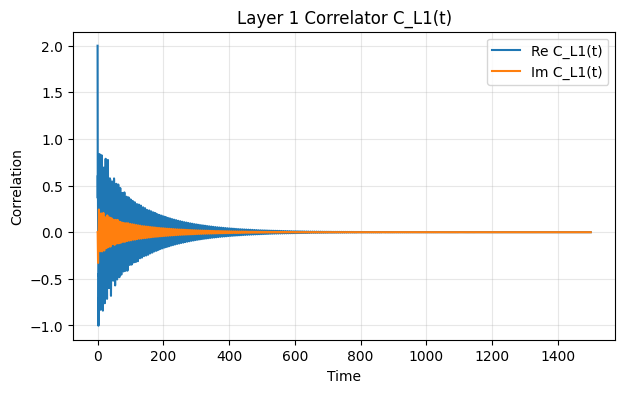

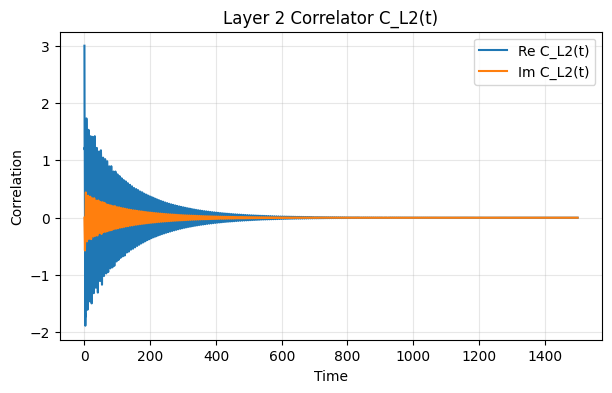

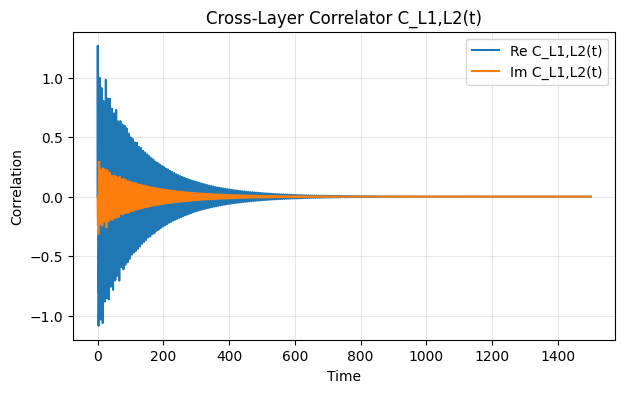

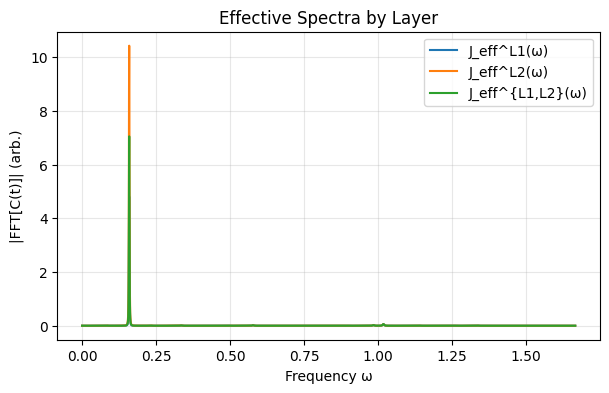

In [3]:
# ========= ONE-AND-DONE: L1, L2, and cross-layer sloshing =========
from qutip import qeye, sigmax, tensor, correlation_2op_1t
import numpy as np, matplotlib.pyplot as plt

# strict check: these must be exported by run_single_simulation(...)
need = [n for n in ["H_total","rho0","tlist","c_ops"] if n not in globals()]
if need:
    raise RuntimeError(f"Missing: {need}. Rerun your sim after adding the single line "
                       "globals().update(dict(H_total=H_total, rho0=rho0, tlist=tlist, c_ops=c_ops, result=result)) "
                       "at the end of run_single_simulation(...).")

t  = np.asarray(tlist, dtype=float)
if len(t) < 2: raise RuntimeError("tlist too short.")
dt = float(t[1] - t[0])
N  = len(H_total.dims[0])

def op_on(op, i, N):
    ops = [qeye(2)] * N
    ops[i] = op
    return tensor(ops)

# Q0 = system, L1 = {1,2}, L2 = {3,4,5}
L1, L2 = [1,2], [3,4,5]
B_L1 = sum(op_on(sigmax(), i, N) for i in L1)
B_L2 = sum(op_on(sigmax(), i, N) for i in L2)

# Two-time correlators
C_L1 = correlation_2op_1t(H_total, rho0, t, c_ops, B_L1, B_L1)
C_L2 = correlation_2op_1t(H_total, rho0, t, c_ops, B_L2, B_L2)
C_X  = correlation_2op_1t(H_total, rho0, t, c_ops, B_L1, B_L2)  # cross-layer

# Spectra (windowed FFT)
window = np.hanning(len(t))
freq   = np.fft.fftshift(np.fft.fftfreq(len(t), d=dt))
J_L1   = np.abs(np.fft.fftshift(np.fft.fft(C_L1 * window))) * dt
J_L2   = np.abs(np.fft.fftshift(np.fft.fft(C_L2 * window))) * dt
J_X    = np.abs(np.fft.fftshift(np.fft.fft(C_X  * window))) * dt
pos    = freq >= 0

# ---- Plots (each its own figure) ----
plt.figure(figsize=(7,4))
plt.plot(t, np.real(C_L1), label="Re C_L1(t)")
plt.plot(t, np.imag(C_L1), label="Im C_L1(t)")
plt.title("Layer 1 Correlator C_L1(t)")
plt.xlabel("Time"); plt.ylabel("Correlation"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(t, np.real(C_L2), label="Re C_L2(t)")
plt.plot(t, np.imag(C_L2), label="Im C_L2(t)")
plt.title("Layer 2 Correlator C_L2(t)")
plt.xlabel("Time"); plt.ylabel("Correlation"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(t, np.real(C_X), label="Re C_L1,L2(t)")
plt.plot(t, np.imag(C_X), label="Im C_L1,L2(t)")
plt.title("Cross-Layer Correlator C_L1,L2(t)")
plt.xlabel("Time"); plt.ylabel("Correlation"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(freq[pos], J_L1[pos], label="J_eff^L1(ω)")
plt.plot(freq[pos], J_L2[pos], label="J_eff^L2(ω)")
plt.plot(freq[pos], J_X[pos],  label="J_eff^{L1,L2}(ω)")
plt.title("Effective Spectra by Layer")
plt.xlabel("Frequency ω"); plt.ylabel("|FFT[C(t)]| (arb.)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()
# ================================================================



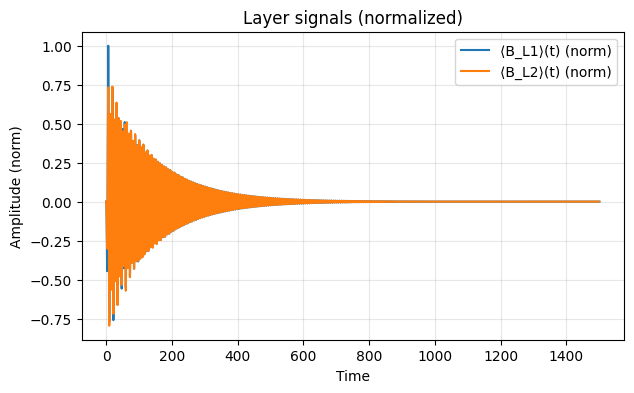

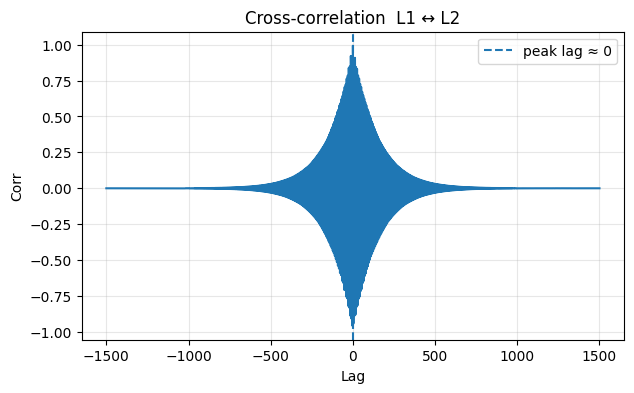

In [4]:
# ==== Measure sloshing delay via lagged cross-correlation (run AFTER your sim) ====
import numpy as np, matplotlib.pyplot as plt
from qutip import qeye, sigmax, tensor, expect

# need result + H_total/tlist exported by your run_single_simulation(...)
need = [n for n in ["result","H_total","tlist"] if n not in globals()]
if need:
    raise RuntimeError(f"Missing: {need}. Rerun your sim with the globals().update(...) export.")

t   = np.asarray(tlist, dtype=float)
dt  = float(t[1]-t[0])
sts = result.states
N   = len(sts[0].dims[0])

def op_on(op, i, N):
    ops = [qeye(2)] * N
    ops[i] = op
    return tensor(ops)

# Q0 system, L1={1,2}, L2={3,4,5}
L1, L2 = [1,2], [3,4,5]
B_L1 = sum(op_on(sigmax(), i, N) for i in L1)
B_L2 = sum(op_on(sigmax(), i, N) for i in L2)

# Time-series signals
BL1 = np.array([expect(B_L1, s) for s in sts], dtype=float)
BL2 = np.array([expect(B_L2, s) for s in sts], dtype=float)

# Detrend + normalize (helps cross-corr)
BL1z = BL1 - BL1.mean();  BL2z = BL2 - BL2.mean()
s1   = BL1z / (BL1z.std() if BL1z.std()!=0 else 1.0)
s2   = BL2z / (BL2z.std() if BL2z.std()!=0 else 1.0)

# Full cross-correlation (s1 leads positive lags)
xc   = np.correlate(s1, s2, mode='full') / len(s1)
lags = np.arange(-len(s1)+1, len(s1)) * dt
imax = int(np.argmax(xc))
lag_peak = lags[imax]   # seconds (or your time units)
peak_val = xc[imax]

print(f"Peak cross-correlation at lag ≈ {lag_peak:.4g} (time units), value ≈ {peak_val:.3f}")
print("Interpretation: positive lag = L1 leads L2 by that delay; negative = L2 leads L1.")

# ---- Plots ----
plt.figure(figsize=(7,4))
m = max(np.max(np.abs(s1)), np.max(np.abs(s2)))
plt.plot(t, s1/m, label="⟨B_L1⟩(t) (norm)")
plt.plot(t, s2/m, label="⟨B_L2⟩(t) (norm)")
plt.title("Layer signals (normalized)"); plt.xlabel("Time"); plt.ylabel("Amplitude (norm)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(lags, xc);
plt.axvline(lag_peak, linestyle='--', label=f"peak lag ≈ {lag_peak:.4g}")
plt.title("Cross-correlation  L1 ↔ L2"); plt.xlabel("Lag"); plt.ylabel("Corr")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()
